# Implementation of Softmax Regression from Scratch

**Just as we implemented linear regression from scratch, we believe that**
softmax regression
is similarly fundamental and
how to implement it yourself.
We will work with the Fashion-MNIST dataset
setting up a data iterator with batch size 256.


In [2]:
#You need this line of code only when you work with google colab
!pip install d2l

import torch
from IPython import display
from d2l import torch as d2l

/Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <ABE0EE74-6D97-3B8C-B690-C44754774FBC> /Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <EA4AB737-8320-3563-ACC4-78D44C0573BA> /Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## Initializing Model Parameters

As in our linear regression example,
each example here will be represented by a fixed-length vector.
Each example in the raw dataset is a $28 \times 28$ image.
In this section, **we will flatten each image,
treating them as vectors of length 784.**
In the future, we will talk about more sophisticated strategies
for exploiting the spatial structure in images,
but for now we treat each pixel location as just another feature.

Recall that in softmax regression,
we have as many outputs as there are classes.
**Because our dataset has 10 classes,
our network will have an output dimension of 10.**
Consequently, our weights will constitute a $784 \times 10$ matrix
and the biases will constitute a $1 \times 10$ row vector.
As with linear regression, we will initialize our weights `W`
with Gaussian noise and our biases to take the initial value 0.


In [4]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## Defining the Softmax Operation

Before implementing the softmax regression model,
let us briefly review how the sum operator works
along specific dimensions in a tensor.
**Given a matrix `X` we can sum over all elements (by default) or only
over elements in the same axis,**
i.e., the same column (axis 0) or the same row (axis 1).
Note that if `X` is a tensor with shape (2, 3)
and we sum over the columns,
the result will be a vector with shape (3,).
When invoking the sum operator,
we can specify to keep the number of axes in the original tensor,
rather than collapsing out the dimension that we summed over.
This will result in a two-dimensional tensor with shape (1, 3).


In [5]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

We are now ready to **implement the softmax operation**.
Recall that softmax consists of three steps:
(i) we exponentiate each term (using `exp`);
(ii) we sum over each row (we have one row per example in the batch)
to get the normalization constant for each example;
(iii) we divide each row by its normalization constant,
ensuring that the result sums to 1.
Before looking at the code, let us recall
how this looks expressed as an equation:

**
$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$
**

The denominator, or normalization constant,
is also sometimes called the *partition function*
(and its logarithm is called the log-partition function).
The origins of that name are in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))
where a related equation models the distribution
over an ensemble of particles.


In [6]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

As you can see, for any random input,
**we turn each element into a non-negative number.
Moreover, each row sums up to 1,**
as is required for a probability.


In [7]:
X = torch.normal(mean=0, std=1, size=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0894, 0.1107, 0.1052, 0.0994, 0.5952],
         [0.4219, 0.1294, 0.0959, 0.1441, 0.2087]]),
 tensor([1.0000, 1.0000]))

Note that while this looks correct mathematically,
we were a bit sloppy in our implementation
because we failed to take precautions against numerical overflow or underflow
due to large or very small elements of the matrix.

## Defining the Model

Now that we have defined the softmax operation,
we can **implement the softmax regression model.**
The below code defines how the input is mapped to the output through the network.
Note that we flatten each original image in the batch
into a vector using the `reshape` function
before passing the data through our model.


In [8]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

## Defining the Loss Function

Next, we need to implement the cross-entropy loss function.
This may be the most common loss function
in all of deep learning because, at the moment,
classification problems far outnumber regression problems.

Recall that cross-entropy takes the negative log-likelihood
of the predicted probability assigned to the true label.
Rather than iterating over the predictions with a Python for-loop
(which tends to be inefficient),
we can pick all elements by a single operator.
Below, we **create sample data `y_hat`
with 2 examples of predicted probabilities over 3 classes and their corresponding labels `y`.**
With `y` we know that in the first example the first class is the correct prediction and
in the second example the third class is the ground-truth.
**Using `y` as the indices of the probabilities in `y_hat`,**
we pick the probability of the first class in the first example
and the probability of the third class in the second example.


In [9]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

Now we can **implement the cross-entropy loss function** efficiently with just one line of code.

In [10]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

## Classification Accuracy

Given the predicted probability distribution `y_hat`,
we typically choose the class with the highest predicted probability
whenever we must output a hard prediction.
Indeed, many applications require that we make a choice.
Gmail must categorize an email into "Primary", "Social", "Updates", or "Forums".
It might estimate probabilities internally,
but at the end of the day it has to choose one among the classes.

When predictions are consistent with the label class `y`, they are correct.
The classification accuracy is the fraction of all predictions that are correct.
Although it can be difficult to optimize accuracy directly (it is not differentiable),
it is often the performance measure that we care most about,
and we will nearly always report it when training classifiers.

To compute accuracy we do the following.
First, if `y_hat` is a matrix,
we assume that the second dimension stores prediction scores for each class.
We use `argmax` to obtain the predicted class by the index for the largest entry in each row.
Then we **compare the predicted class with the ground-truth `y` elementwise.**
Since the equality operator `==` is sensitive to data types,
we convert `y_hat`'s data type to match that of `y`.
The result is a tensor containing entries of 0 (false) and 1 (true).
Taking the sum yields the number of correct predictions.


In [11]:
def accuracy(y_hat, y): 
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

We will continue to use the variables `y_hat` and `y`
defined before
as the predicted probability distributions and labels, respectively.
We can see that the first example's prediction class is 2
(the largest element of the row is 0.6 with the index 2),
which is inconsistent with the actual label, 0.
The second example's prediction class is 2
(the largest element of the row is 0.5 with the index of 2),
which is consistent with the actual label, 2.
Therefore, the classification accuracy rate for these two examples is 0.5.


In [12]:
accuracy(y_hat, y) / len(y)

0.5

**Similarly, we can evaluate the accuracy for any model `net` on a dataset**
that is accessed via the data iterator `data_iter`.


In [13]:
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

Here `Accumulator` is a utility class to accumulate sums over multiple variables.
In the above `evaluate_accuracy` function,
we create 2 variables in the `Accumulator` instance for storing both
the number of correct predictions and the number of predictions, respectively.
Both will be accumulated over time as we iterate over the dataset.


In [14]:
class Accumulator: 
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

**Because we initialized the `net` model with random weights,
the accuracy of this model should be close to random guessing,**
i.e., 0.1 for 10 classes.


In [15]:
evaluate_accuracy(net, test_iter)

/Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <ABE0EE74-6D97-3B8C-B690-C44754774FBC> /Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <EA4AB737-8320-3563-ACC4-78D44C0573BA> /Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/U

0.1542

## Training

**The training loop**
for softmax regression should look strikingly familiar
if you read through our implementation
of linear regression.
Here we refactor the implementation to make it reusable.
First, we define a function to train for one epoch.
Note that `updater` is a general function to update the model parameters,
which accepts the batch size as an argument.
It can be either a wrapper of the `d2l.sgd` function
or a framework's built-in optimization function. For the definition of the updater function look see below.


In [16]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    # Setting the model is important for some types of layers we will talk later about
    # Layers like Batch normalization of dropout will behave different in .train() or .eval() mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

Before showing the implementation of the training function,
we define **a utility class that plot data in animation.**
Again, it aims to simplify code in the rest of the book (it is not that important to understand this code)


In [17]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        # You can read more about lambda functions here https://www.w3schools.com/python/python_lambda.asp
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

The following training function then
trains a model `net` on a training dataset accessed via `train_iter`
for multiple epochs, which is specified by `num_epochs`.
At the end of each epoch,
the model is evaluated on a testing dataset accessed via `test_iter`.
We will leverage the `Animator` class to visualize
the training progress. You can find more on the assert statement in https://www.w3schools.com/python/ref_keyword_assert.asp. If a condition is not fulfilled,assert throws the so-called assertion error.


In [18]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    #condition is train_loss < 0.5, assertion error is train_loss
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

As an implementation from scratch,
we **use the minibatch stochastic gradient descent** to optimize the loss function of the model with a learning rate 0.1.


In [19]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

Now we **train the model with 10 epochs.**
Note that both the number of epochs (`num_epochs`),
and learning rate (`lr`) are adjustable hyperparameters.
By changing their values, we may be able
to increase the classification accuracy of the model. Sometimes it is a better idea to use a method called early stopping as an automatism for adjusting the number of epochs instead of setting it as a hyperparameter.


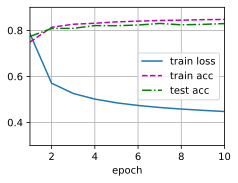

In [20]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## Prediction

Now that training is complete,
our model is ready to **classify some images.**
Given a series of images,
we will compare their actual labels
(first line of text output)
and the predictions from the model
(second line of text output).


/Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <ABE0EE74-6D97-3B8C-B690-C44754774FBC> /Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <EA4AB737-8320-3563-ACC4-78D44C0573BA> /Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/jaschob/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/U

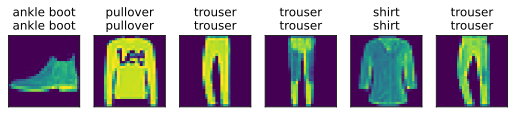

In [21]:
def predict_ch3(net, test_iter, n=6):
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## Summary

* With softmax regression, we can train models for multiclass classification.
* The training loop of softmax regression is very similar to that in linear regression: retrieve and read data, define models and loss functions, then train models using optimization algorithms. As you will soon find out, most common deep learning models have similar training procedures.


## Exercises

1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. What problems might this cause? Hint: try to calculate the size of $\exp(50)$. What can you do to solve this problem?

2. The function `cross_entropy` in this section was implemented according to the definition of the cross-entropy loss function.  What could be the problem with this implementation? Hint: consider the domain of the logarithm. Why is it a bit problematic to add a small constant to the class with probability zero?

3. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?


[Discussions](https://discuss.d2l.ai/t/51)
